In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


C:\Users\asus\AppData\Local\Temp\ipykernel_16464\2049556105.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


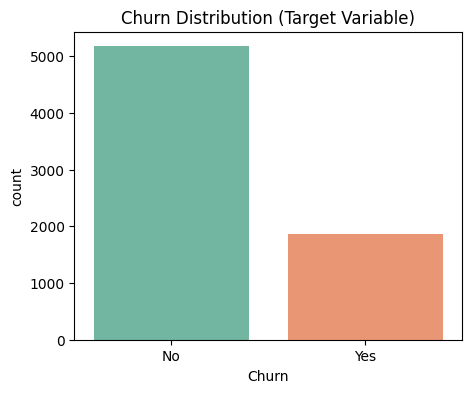

In [6]:
import seaborn as sns

# 1.churn distribution
X = df.drop("Churn", axis=1)
y = df["Churn"]

sns.countplot(x=y, palette="Set2")
plt.title("Churn Distribution (Target Variable)")
plt.show()

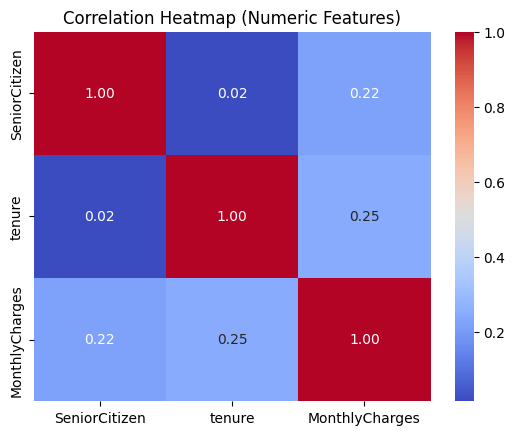

In [8]:
# 2. Correlation heatmap for numeric features
cat_cols = df.select_dtypes(include=["object"]).columns
num_cols = df.select_dtypes(exclude=["object"]).columns

sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

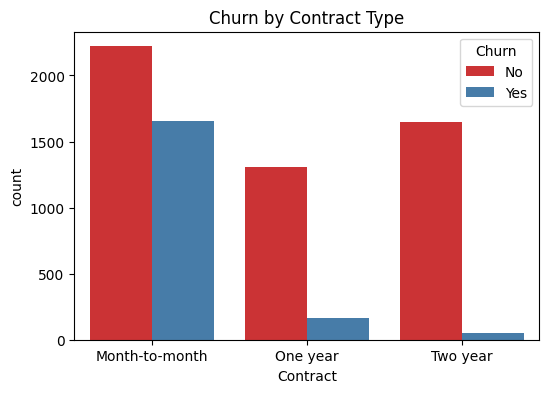

In [9]:
# 3. Categorical variable distribution (example: 'Contract')
plt.figure(figsize=(6,4))
sns.countplot(x="Contract", hue="Churn", data=df, palette="Set1")
plt.title("Churn by Contract Type")
plt.show()

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config


In [20]:
# Convert 'TotalCharges' to numeric (sometimes it's object type)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Numeric preprocessing: handle missing + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing: handle missing + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [22]:
# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [23]:
# Final pipeline (just preprocessing, no model yet)
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
pipeline.fit(X_train)
set_config(display="diagram")  
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))]))])

In [17]:
#1:-Logistics Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),  
    ("model", LogisticRegression(max_iter=1000))
])

clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)


In [18]:
print("\nModel: Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))
cv_scores = cross_val_score(clf_lr, X, y, cv=5, scoring="accuracy")
print("Cross-Val Mean Score:", np.mean(cv_scores))


Model: Logistic Regression
              precision    recall  f1-score   support

          No       0.86      0.90      0.88      1036
         Yes       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409

Confusion Matrix:
 [[933 103]
 [149 224]]
Accuracy Score: 0.8211497515968772
Cross-Val Mean Score: 0.8044875879088973


In [24]:
#2:- Random Forest 
clf_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

In [25]:
# Evaluation
print("\nModel: Random Forest")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
cv_scores = cross_val_score(clf_rf, X, y, cv=5, scoring="accuracy")
print("Cross-Val Mean Score:", np.mean(cv_scores))



Model: Random Forest
              precision    recall  f1-score   support

          No       0.83      0.91      0.87      1036
         Yes       0.66      0.47      0.55       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Confusion Matrix:
 [[944  92]
 [198 175]]
Accuracy Score: 0.794180269694819
Cross-Val Mean Score: 0.7874502992128525


In [26]:
#3:-Gradient Boosting
clf_gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

clf_gb.fit(X_train, y_train)
y_pred_gb = clf_gb.predict(X_test)



In [27]:
# Evaluation
print("\nModel: Gradient Boosting")
print(classification_report(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("Accuracy Score:", accuracy_score(y_test, y_pred_gb))
cv_scores = cross_val_score(clf_gb, X, y, cv=5, scoring="accuracy")
print("Cross-Val Mean Score:", np.mean(cv_scores))


Model: Gradient Boosting
              precision    recall  f1-score   support

          No       0.84      0.91      0.87      1036
         Yes       0.67      0.53      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix:
 [[941  95]
 [176 197]]
Accuracy Score: 0.8076650106458482
Cross-Val Mean Score: 0.8067595086779793


In [28]:
#4:-XG Boost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [29]:
clf_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(eval_metric='logloss', random_state=42))
])

clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

In [30]:
print("\nModel: XGBoost")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))

cv_scores = cross_val_score(clf_xgb, X, y, cv=5, scoring="accuracy")
print("Cross-Val Mean Score:", np.mean(cv_scores))



Model: XGBoost
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.61      0.54      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

Confusion Matrix:
 [[903 132]
 [171 203]]
Accuracy Score: 0.7849538679914834
Cross-Val Mean Score: 0.7846105998774116


Conclusion :- Logistic Regression is the best choice here due to the highest overall accuracy, balanced precision–recall, and strong cross-validation score. Gradient Boosting could be a good alternative if we use non-linear modeling power.

In [34]:
import pandas as pd
import joblib

# Load saved model
clf_best = joblib.load("best_churn_model.pkl")

# Define input columns
input_columns = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod",
    "MonthlyCharges", "TotalCharges"
]

M
customer_data = {}
customer_data["gender"] = input("Enter Gender (Male/Female): ")
customer_data["SeniorCitizen"] = int(input("Senior Citizen? (0 = No, 1 = Yes): "))
customer_data["Partner"] = input("Partner (Yes/No): ")
customer_data["Dependents"] = input("Dependents (Yes/No): ")
customer_data["tenure"] = int(input("Tenure (months stayed): "))
customer_data["PhoneService"] = input("Phone Service (Yes/No): ")
customer_data["MultipleLines"] = input("Multiple Lines (Yes/No/No phone service): ")
customer_data["InternetService"] = input("Internet Service (DSL/Fiber optic/No): ")
customer_data["OnlineSecurity"] = input("Online Security (Yes/No/No internet service): ")
customer_data["OnlineBackup"] = input("Online Backup (Yes/No/No internet service): ")
customer_data["DeviceProtection"] = input("Device Protection (Yes/No/No internet service): ")
customer_data["TechSupport"] = input("Tech Support (Yes/No/No internet service): ")
customer_data["StreamingTV"] = input("Streaming TV (Yes/No/No internet service): ")
customer_data["StreamingMovies"] = input("Streaming Movies (Yes/No/No internet service): ")
customer_data["Contract"] = input("Contract (Month-to-month/One year/Two year): ")
customer_data["PaperlessBilling"] = input("Paperless Billing (Yes/No): ")
customer_data["PaymentMethod"] = input("Payment Method (Electronic check/Mailed check/Bank transfer/Credit card): ")
customer_data["MonthlyCharges"] = float(input("Monthly Charges: "))
customer_data["TotalCharges"] = float(input("Total Charges: "))

# Convert to DataFrame
new_customer = pd.DataFrame([customer_data], columns=input_columns)

# Predict churn
prediction = clf_best.predict(new_customer)[0]
probability = clf_best.predict_proba(new_customer)[0, 1]

# Show result
print("\n--- Prediction Result ---")
print("Churn Prediction:", "Churn" if prediction == 1 else "No Churn")
print(f"Churn Probability: {probability:.2f}")


Enter Gender (Male/Female):  Male
Senior Citizen? (0 = No, 1 = Yes):  0
Partner (Yes/No):  No
Dependents (Yes/No):  Yes
Tenure (months):  4
Phone Service (Yes/No):  Yes
Multiple Lines (Yes/No/No phone service):  No
Internet Service (DSL/Fiber optic/No):  No
Online Security (Yes/No/No internet service):  Yes
Online Backup (Yes/No/No internet service):  Yes
Device Protection (Yes/No/No internet service):  Yes
Tech Support (Yes/No/No internet service):  Yes
Streaming TV (Yes/No/No internet service):  Yes
Streaming Movies (Yes/No/No internet service):  Yes
Contract (Month-to-month/One year/Two year):  One Year
Paperless Billing (Yes/No):  Yes
Payment Method (Electronic check/Mailed check/Bank transfer/Credit card):  Credit Card
Monthly Charges:  89.1
Total Charges:  1949.9



--- Prediction Result ---
Churn Prediction: No Churn
Churn Probability: 0.31
